# Проектная работа: принятие решений в бизнесе

Контекст: для обработки предоставлены данные крупного интернет-магазина, а также подготовлен список гипотез для увеличения выручки. Требуется приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

## Загрузка данных и предобработка

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import pandas as pd
import numpy as np
import re

In [2]:
visitors = pd.read_csv('D:\\ds\\visitors.csv')
orders = pd.read_csv('D:\\ds\\orders.csv')
hypothesis = pd.read_csv('D:\\ds\\hypothesis.csv')
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 200)

In [3]:
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

def prep(dataframe):
    dataframe = dataframe.drop_duplicates()
    dataframe.columns = [camel_to_snake(col) for col in dataframe.columns]
    dataframe.columns = dataframe.columns.str.replace(' ', '_')
    return dataframe

def get_info(dataframe):
    display(dataframe.head(5))
    print('*'*50)
    dataframe.info()
    print('*'*50)
    print(f"Явных дубликатов: {dataframe.duplicated().sum()}")
    print('*'*25)
    print('Пропусков в колонках:')
    print(dataframe.isna().sum())

In [4]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [5]:
hypothesis = prep(hypothesis)
orders = prep(orders)

In [6]:
get_info(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
**************************************************
Явных дубликатов: 0
*************************
Пропусков в колонках:
date        0
group       0
visitors    0
dtype: int64


In [7]:
get_info(orders)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


**************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 56.1+ KB
**************************************************
Явных дубликатов: 0
*************************
Пропусков в колонках:
transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64


In [8]:
get_info(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


**************************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 432.0+ bytes
**************************************************
Явных дубликатов: 0
*************************
Пропусков в колонках:
hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64


В ходе предобработки отформатированы для дальнейшей обработки данные в колонках с датами, а также приведены к змеиному регистру заголовки колонок.<br><br>
Явных дублей нет, но есть смысл поискать неявные. Не попал ли кто из пользователей в обе группы?

In [9]:
user_doubles = orders.groupby('visitor_id')['group'].nunique()
print(len(user_doubles[user_doubles > 1].index.tolist()))

58


Попал. По-хорошему надо их исключать, но таблица visitors содержит агрегированные данные с учётом этих пользователей и править её возможности нет, так что считать придётся как есть.

## Приоритизация гипотез

В файле hypothesis.csv содержится 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Используя фреймворки ICE и RICE требуется отсортировать их по убыванию приоритета.

### Фреймворк ICE

In [10]:
ice = hypothesis.copy()
ice['ICE'] = (ice['impact'] * ice['confidence']) / ice['efforts']
ice = ice.sort_values(by='ICE', ascending=False)
ice['ICE'] = ice['ICE'].apply(lambda x: "{:.2f}".format(x))
ice[['hypothesis', 'ICE']]

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Фреймворк RICE

In [11]:
rice = hypothesis.copy()
rice['RICE'] = (rice['impact'] * rice['confidence'] * rice['reach']) / rice['efforts']
rice = rice.sort_values(by='RICE', ascending=False)
rice['RICE'] = rice['RICE'].apply(lambda x: "{:.2f}".format(x))
rice[['hypothesis', 'RICE']]

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Главное различие между фреймворками заключается в том, что RICE учитывает дополнительный критерий Reach (Охват). Это позволяет более точно оценивать, насколько широкую аудиторию затронет проект или идея. В результате добавления этого критерия может изменяться порядок приоритизации, так как проект с высоким охватом, даже если его выполнение сложнее, может получить более высокий балл.<br><br>
В данном случае идея #7 при оценке фреймворком RICE получает максимальный приоритет, т.к. её реализация охватывает большую аудиторию по сравнению с идеей #8, имеющую максимальный приоритет при оценке ICE.

## Анализ A/B-теста

Результаты проведенного A/B-теста описаны в файлах orders.csv и visitors.csv

При анализе результатов A/B-теста используются графики кумулятивных метрик, которые:
- помогают визуализировать, как метрики меняются со временем. Это позволяет увидеть тренды и убедиться, что результаты теста стабилизируются по мере увеличения количества данных. Если кумулятивная метрика стабильно стремится к определённому значению, это хороший признак того, что результаты теста надёжны.
- позволяют выявлять аномалии или неожиданные изменения на ранних стадиях эксперимента. Например, если на графике видно резкое изменение кумулятивной метрики в определённый момент времени, это может сигнализировать о проблеме с данными или об изменении поведения пользователей, требующем дополнительного анализа.
- помогают оценить, когда разница между контрольной и тестовой группой становится статистически значимой. Это важно для принятия решения о завершении теста или продолжении сбора данных. Если кумулятивная разница между группами стабилизируется и остаётся значимой на протяжении длительного времени, это может быть признаком того, что эффект является настоящим, а не случайным.
- позволяют визуализировать эффект, который оказывает тестируемая переменная на ключевые показатели. Это помогает лучше понять, как тестируемая гипотеза влияет на поведение пользователей на протяжении всего периода эксперимента, а не только в его конечной точке.

Чтобы построить графики, прежде всего нужно собрать кумулятивные данные в таблицу:
- создать массив уникальных пар значений дат и групп теста
- получить агрегированные кумулятивные по дням данные о заказах
- получить агрегированные кумулятивные по дням данные о посетителях интернет-магазина
- объединить кумулятивные данные в одной таблице и присвоить её столбцам понятные названия

In [13]:
dates_grps = orders[['date','group']].drop_duplicates()

orders_agg = dates_grps.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'}), axis=1
).sort_values(by=['date', 'group'])

visitors_agg = dates_grps.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1
).sort_values(by=['date','group'])

cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
print(cumulative_data.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


### График кумулятивной выручки по группам

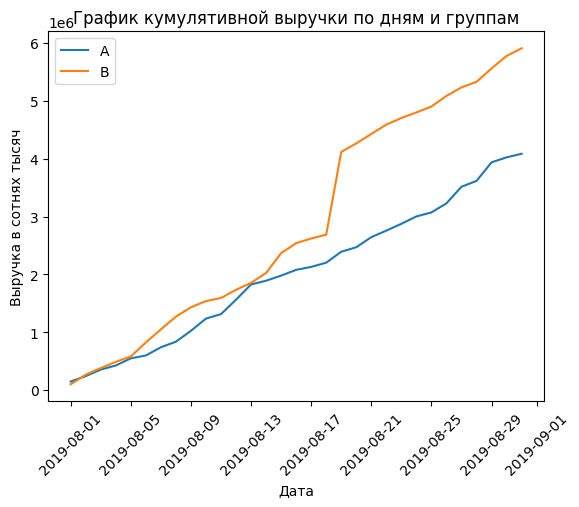

In [14]:
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('График кумулятивной выручки по дням и группам')
plt.xlabel('Дата')
plt.ylabel('Выручка в сотнях тысяч')
plt.xticks(rotation=45)
plt.legend();

В первой половине теста выручка в группе B немного выше, чем в группе А. Во второй половине наблюдается резкий рост группы B. Здесь либо резко увеличилась конверсия, либо внезапно вырос средний чек, либо появилась аномалия. Выручка в группе А сохраняет равномерный рост на протяжение всего теста. 

### График кумулятивного среднего чека по группам

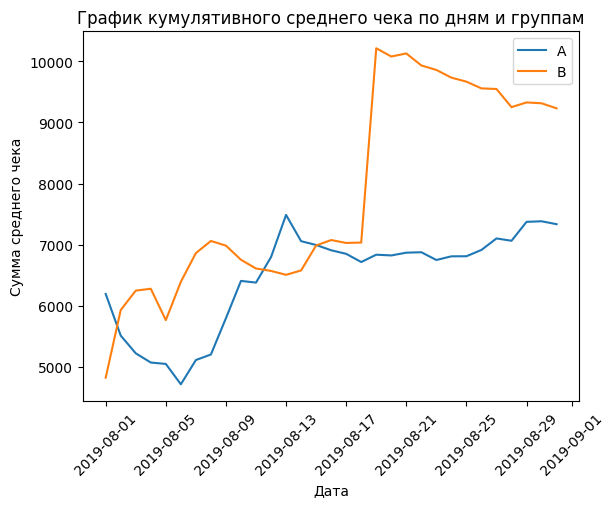

In [15]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], label='B')
plt.title('График кумулятивного среднего чека по дням и группам')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.xticks(rotation=45)
plt.legend(); 

Резкий скачок в группе B выглядит ещё более аномальным. Размер среднего чека в группе А также нестабилен в первой половине теста, но перепады более постепенные и не выглядят слишком странно.

### График относительного изменения кумулятивного среднего чека группы B к группе A

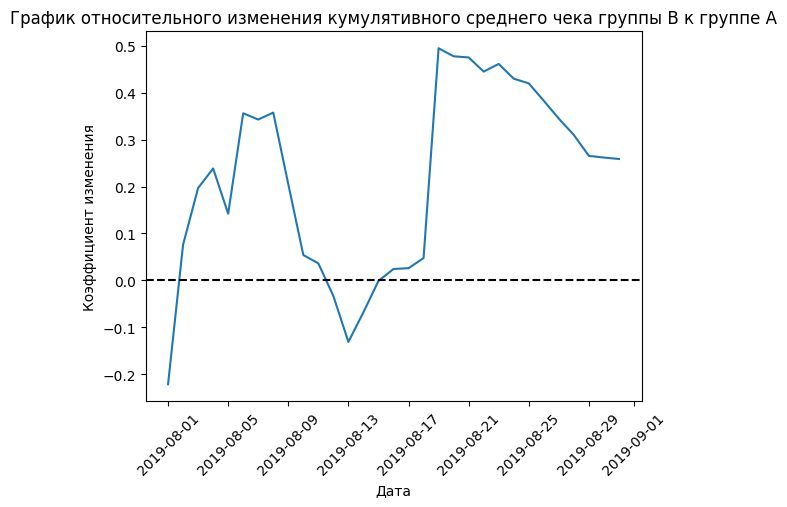

In [16]:
merged_cumulative_revenue = cumulative_revenue_a.merge(
     cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_b'] / \
     merged_cumulative_revenue['orders_b']) / \
    (merged_cumulative_revenue['revenue_a'] / merged_cumulative_revenue['orders_a']) - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Коэффициент изменения')
plt.xticks(rotation=45);

Разница в среднем чеке между группами нестабильна и имеет резкие перепады.

### График кумулятивного среднего количества заказов на посетителя по группам

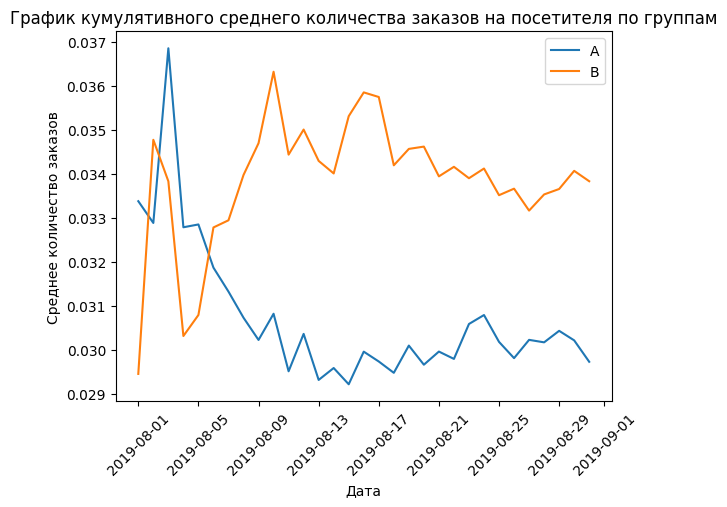

In [18]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.xticks(rotation=45)
plt.legend();

Группа А стартует с более высоких показателей и на старте в обеих группах происходит резкий скачок вверх-вниз, после чего группа А продолжает падение, а группа B начинает рост по количеству заказов. 

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

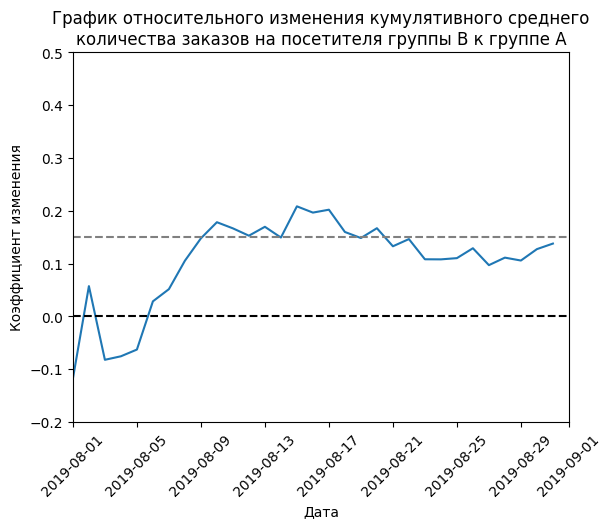

In [19]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(
         cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversion_b'] / \
         merged_cumulative_conversions['conversion_a'] - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего\nколичества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Коэффициент изменения')
plt.axis([pd.to_datetime('2019-08-01'), pd.to_datetime('2019-09-01'), -0.2, 0.5])
plt.xticks(rotation=45);

Коэффициент относительного изменения среднего количества заказов стабилизируется ближе ко второй половине теста и показывает превышающий группу А результат.

### Точечный график количества заказов по пользователям

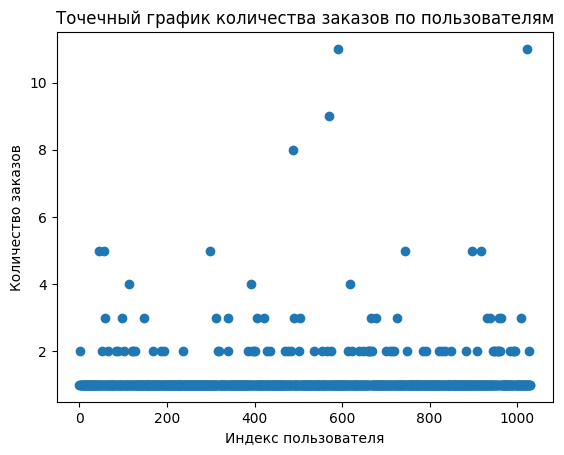

In [20]:
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users.columns = ['user_id', 'orders']
x_values_orders = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values_orders, orders_by_users['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Индекс пользователя')
plt.ylabel('Количество заказов'); 

Более двух заказов на пользователя - редкий показатель.

### 95-й и 99-й перцентили количества заказов на пользователя

In [22]:
print(np.percentile(orders_by_users['orders'], [95, 99])) 

[2. 4.]


Предположение подтверждается 95-м перцентилем. Только 5% пользователей совершили более 2 покупок.

### Точечный график стоимостей заказов

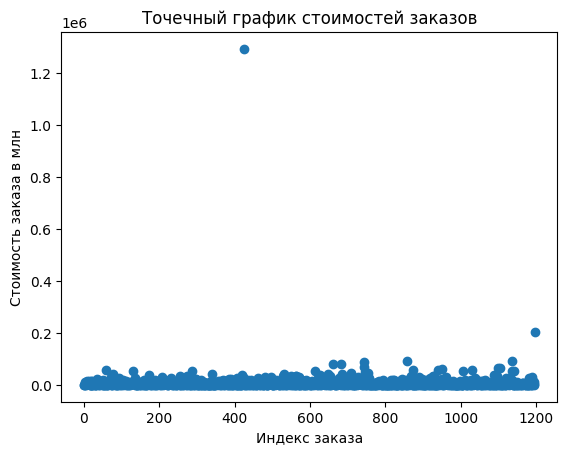

In [23]:
x_values_revenue = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values_revenue, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Индекс заказа')
plt.ylabel('Стоимость заказа в млн'); 

In [24]:
orders['revenue'].describe().astype(str)

count               1197.0
mean     8348.005847953216
std      39191.13177395123
min                   50.0
25%                 1220.0
50%                 2978.0
75%                 8290.0
max              1294500.0
Name: revenue, dtype: object

Здесь отлично видно имеющуюся аномалию - это заказ стоимостью почти 1,3 млн при том, что сумма типичного заказа около 3к.

### 95-й и 99-й перцентили стоимости заказов

In [25]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% заказов превышают сумму в 28к, не более 1% - 58,2к.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаю статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.<br><br>
Гипотезы:<br> 
**Н0:** различий в среднем количестве заказов между группами нет. <br>
**Н1:** различия в среднем между группами есть.<br>
**Уровень значимости:** α = 0.05<br><br>
В данном случае, учитывая наличие выбросов и предположительное несоответствие нормальному распределению, будет применяться непараметрический тест Уилкоксона-Манна-Уитни.<br><br>
Сперва нужно подготовить данные.

In [26]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']]
    .agg({'date': 'max', 'visitors_per_date_a':'sum'}), axis=1)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']]
    .agg({'date':'max', 'visitors_per_date_b':'sum'}), axis=1)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue':'sum'}))
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']]
    .agg({'date':'max', 'orders_per_date_a':'sum', 'revenue_per_date_a':'sum'}), axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = ['date', 'orders_cummulative_a', 'revenue_cummulative_a']

orders_b_daily = (orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue':'sum'}))
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']]
    .agg({'date':'max', 'orders_per_date_b':'sum', 'revenue_per_date_b':'sum'}), axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b',]

data = (orders_a_daily
    .merge(orders_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left'))

print(data.head(5))

        date  orders_per_date_a  revenue_per_date_a  orders_per_date_b  \
0 2019-08-01                 24              148579                 21   
1 2019-08-02                 20               93822                 24   
2 2019-08-03                 24              112473                 16   
3 2019-08-04                 16               70825                 17   
4 2019-08-05                 25              124218                 23   

   revenue_per_date_b  orders_cummulative_a_x  revenue_cummulative_a_x  \
0              101217                      24                   148579   
1              165531                      44                   242401   
2              114248                      68                   354874   
3              108571                      84                   425699   
4               92428                     109                   549917   

   orders_cummulative_b_x  revenue_cummulative_b_x  visitors_per_date_a  \
0                      21          

In [27]:
orders_by_users_a = (orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique}))
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique}))
orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)

sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0)

In [28]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print("Изменение группы B к А: {0:.1f}%".format((sample_b.mean() / sample_a.mean() - 1) * 100))

p-value: 0.017
Изменение группы B к А: 13.8%


P-value ниже уровня стат.значимости, следовательно нулевая гипотеза о том, что среднее количество заказов в двух группах равно, отвергается. При этом количество заказов в группе B превышает группу А на 13,8%.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

**Н0:** различий в среднем чеке заказа между группами нет. <br>
**Н1:** различия в среднем между группами есть.<br>
**Уровень значимости:** α = 0.05

In [29]:
print("p-value: {0:.3f}"
      .format(stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))
print("Изменение группы B к А: {0:.1f}%"
      .format((orders[orders['group'] == 'B']['revenue'].mean() / \
               orders[orders['group'] == 'A']['revenue'].mean() - 1) * 100))

p-value: 0.729
Изменение группы B к А: 25.9%


P-value значительно больше уровня стат.значимости, следовательно нулевая гипотеза признаётся верной. При этом по сырым данным группа B показывает прирост среднего чека на 25,9%.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

**Н0:** различий в среднем количестве заказов между группами нет. <br>
**Н1:** различия в среднем между группами есть.<br>
**Уровень значимости:** α = 0.05

Чтоб очистить данные, нужно отсечь их часть по границам 95 и 99-перцентилей, которые были определены ранее. Для этого выберу id пользователей, чьё количество и сумма заказов признаны аномальными: 5% пользователей с наибольшем количеством заказов и от 1 до 5% с наибольшей суммой заказа (более 35к).

In [30]:
users_with_many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > 2]['visitor_id'],
                                    orders_by_users_b[orders_by_users_b['orders'] > 2]['visitor_id']], axis=0)

users_with_expensive_orders = orders[orders['revenue'] > 35000]['visitor_id']
abnormal_users = pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0).drop_duplicates().sort_values()

print('Список аномальных пользователей:')
print(abnormal_users.head(5))
print()
print('Количество аномальных пользователей:', abnormal_users.shape[0]) 

Список аномальных пользователей:
1099    148427295
18      199603092
23      237748145
37      249864742
684     358944393
Name: visitor_id, dtype: int64

Количество аномальных пользователей: 53


In [31]:
sample_a_filtered = pd.concat(
    [orders_by_users_a[np.logical_not(
        orders_by_users_a['visitor_id'].isin(abnormal_users))]['orders'], pd.Series(0, index=np.arange(
            data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)

sample_b_filtered = pd.concat(
    [orders_by_users_b[np.logical_not(
        orders_by_users_b['visitor_id'].isin(abnormal_users))]['orders'], pd.Series(0, index=np.arange(
            data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0)

In [32]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print("Изменение группы B к А: {0:.1f}%".format((sample_b_filtered.mean() / sample_a_filtered.mean() - 1) * 100))

p-value: 0.010
Изменение группы B к А: 17.9%


Нулевая гипотеза, как и в случае с сырыми данными, отвергается. Уровень изменения среднего количества заказов на очищенных данных чуть выше и составляет 17,9%.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

**Н0:** различий в среднем чеке заказа между группами нет. <br>
**Н1:** различия в среднем между группами есть.<br>
**Уровень значимости:** α = 0.05

In [33]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(
    orders['visitor_id'].isin(abnormal_users)))]['revenue'], orders[np.logical_and(
        orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1]))

print("Изменение группы B к А: {0:.1f}%".format(
    (orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id']
                                                                  .isin(abnormal_users)))]['revenue'].mean() / 
     orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id']
                                                                  .isin(abnormal_users)))]['revenue'].mean() - 1) * 100))

p-value: 0.885
Изменение группы B к А: 2.2%


На основании p-value нулевая гипотеза о равенстве средних чеков признаётся верной, при этом очищенные данные показывают, что разница в среднем чеке между группами составляет всего 2,2% против 25,9% на сырых данных.

### Решение по результатам теста

Анализ результатов показал прирост конверсии в группе В и увеличение количества заказов при равенстве суммы средних чеков. На основании этого принимается решение остановить тест, зафиксировав победу группы B. 

## Общий вывод

1. Была выявляена ошибка при формировании групп: 58 пользователей оказались включены в обе группы. Устранить ошибку в предоставленных данных не представляется возможным.
2. При помощи фреймворков ICE и RICE проведена приоритезация идей для последующей формулировки и проверки гипотез.
3. Визуализация кумулятивных метрик позволила оценить изменение данных в ходе теста и составить общее представление о течении исследования.
4. В результате анализа данных были выявлены и исключены аномалии, влияющие на статистический критерий по резульатам которого принимается решение о завершении либо продлении A/B теста.
5. Тест показал увеличение кумулятивной средней выручки и количества заказов в группе B, при неизменности среднего чека.